## Dependencies

In [2]:
# !pip install --force-reinstall torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --user --extra-index-url https://download.pytorch.org/whl/cu113

In [13]:
# !pip install torch==1.11.0+cu113 --user --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [3]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

## Sketch2Paint

In [1]:
import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import numpy as np
from diffusers.utils import load_image
from diffusers import AutoencoderKL

In [2]:
import cv2
import numpy as np



# Reshape the Image to fit ControlNet model input (512*512)
def re_image(image=None):
    # Check the image
    if image is None:
        print("Error: No image.")
        return

    # Convert the image to a numpy array if it isn't already
    if not isinstance(image, np.ndarray):
        img = np.array(image)
    else:
        img = image

    # Preparing Canvas
    height, width, _ = img.shape
    longer_side = max(height, width)
    square_canvas = 255 * np.ones((longer_side, longer_side, 3), dtype=np.uint8)

    y_offset = (longer_side - height) // 2
    x_offset = (longer_side - width) // 2

    square_canvas[y_offset:y_offset + height, x_offset:x_offset + width] = img

    # Resize the image to 512x512 pixels
    resized_img = cv2.resize(square_canvas, (512, 512), interpolation=cv2.INTER_AREA)

    return resized_img


In [19]:
pipe1 = None
def init_Sketch2Paint():

    global pipe1
    controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
    )
    # lllyasviel/sd-controlnet-canny
    
    
    pipe1 = StableDiffusionControlNetPipeline.from_pretrained(
        "Linaqruf/anything-v3.0", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
    )#stablediffusionapi/anything-v5 #andite/anything-v4.0 #Linaqruf/anything-v3.0

    pipe1.scheduler = UniPCMultistepScheduler.from_config(pipe1.scheduler.config)
    
    vae = AutoencoderKL.from_pretrained("Catears/AnythingV3VAE",torch_dtype=torch.float16).to("cuda") #stabilityai/sd-vae-ft-mse
    
#     vae = AutoencoderKL.from_pretrained("C:/Users/wz148/.cache/huggingface/hub/models--stablediffusionapi--anything-v5/snapshots/cca72604805bef7cd46b4e5bed414026acbe101e/vae",torch_dtype=torch.float16).to("cuda") #stabilityai/sd-vae-ft-mse
    pipe1.vae = vae

    # Remove if you do not have xformers installed
    # see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
    # for installation instructions
#     pipe1.enable_xformers_memory_efficient_attention()

    pipe1.enable_model_cpu_offload()


In [20]:
def sketch2paint(img,text,num=20):
    # without changing the shape
    
    image_re = re_image(image=img)
    
#     height, width, _ = img.shape    
#     image_re = img
    
    image_re0 =Image.fromarray(image_re)

    image = np.array(image_re0)
    low_threshold = 150
    high_threshold = 200
    
    neg_prompt="nsfw, oversaturated, low contrast,underexposed, overexposed, lowres, low quality"

    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
#     print("h: "+str(height)+"w: "+str(width))
    print("starting sketch-to-paint process...")
    global pipe1
    image1 = pipe1(text, image, num_images_per_prompt=1, num_inference_steps=int(num),height=512, width=512,guidance_scale=6,negative_prompt=neg_prompt,controlnet_conditioning_scale=0.9).images[0] #generator=torch.manual_seed(seed)
    image1.save("Colorization_output.png")
    
    return image1

In [21]:
init_Sketch2Paint()

safety_checker\model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
import numpy as np
import gradio as gr

# def generate(img): #fake generate
#     return img
css='''
.container {max-width: 1150px;margin: auto;padding-top: 1.5rem}
.image_upload{min-height:500px}
.image_upload [data-testid="image"], .image_upload [data-testid="image"] > div{min-height: 500px}
.image_upload [data-testid="sketch"], .image_upload [data-testid="sketch"] > div{min-height: 500px}
.image_upload .touch-none{display: flex}
#output_image{min-height:500px;max-height=500px;}
'''

example_button=gr.Button(label='example',value='Use Result as New Input').style(full_width=False, size='sm')
def example_fill1():

  return Image.open('Sketch_1.jpeg')



with gr.Blocks(theme=gr.themes.Default(font=[gr.themes.GoogleFont("IBM Plex Mono"), "ui-monospace","monospace"],
                                       primary_hue="lime",
                                       secondary_hue="emerald",
                                       neutral_hue="slate",
                                       ), css=css) as demo:
    with gr.Accordion('小提示✨', open=False):
        gr.Markdown('1. 请根据描述自行拆分和添加关键词')
        gr.Markdown('2. 关键词描述前先加入best quality, masterpiece等词以保证生成质量')
        gr.Markdown('3. 关键词添加顺序：先描述人（或者主体），后描述物')
        gr.Markdown('4. 需要英文翻译时可以询问采访者~')
        gr.Markdown('5. 右键单击图像保存到本地')
        
    with gr.Row().style(equal_height=True):
        with gr.Column():
            gr.Markdown('### 输入线稿和文字')
#             example_button=gr.Button(value="用刚刚改好的线稿！")
            input_image = gr.Image()
            input_text = gr.Textbox(label="上色文字描述",lines=1)
            generate_button = gr.Button(label="上色🎇", value = "上色🎇")
            

        with gr.Column():  
            gr.Markdown('### 上色结果')   
            output_image = gr.Image() 
#             output_image = gr.Gallery(
#               label="Generated images",
#               show_label=False,
#               elem_id="output_image",
#               ).style(height=512,containter=True)  
            
    

    generate_button.click(fn=sketch2paint, inputs =[input_image, input_text], outputs=[output_image])
    example_button.click(fn=example_fill1, outputs=[input_image])        
# demo = gr.Interface(sketch2paint, [gr.Image(shape=(200, 200)),gr.Textbox(lines=1)], "image",css=css)

demo.queue().launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


KeyError: 0

starting sketch-to-paint process...


  0%|          | 0/20 [00:00<?, ?it/s]

# Basic Diffusion

In [8]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import UniPCMultistepScheduler


pipe2 = StableDiffusionPipeline.from_pretrained("Linaqruf/anything-v3.0", torch_dtype=torch.float16,safety_checker=None)
pipe2 = pipe2.to("cuda")

pipe2.scheduler = UniPCMultistepScheduler.from_config(pipe2.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
# pipe.enable_xformers_memory_efficient_attention()

pipe2.enable_model_cpu_offload()

def sdgenerate(prompt):

    image = pipe2(prompt=prompt,height=512, width=512,num_inference_steps=20,guidance_scale =10, ).images[0]
    image.save("Basicsd.png")
    return image

text_encoder\model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
import gradio as gr
demo = gr.Interface(sdgenerate, gr.Textbox(lines=1), "image")

demo.queue().launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/20 [00:00<?, ?it/s]

## Lineart Test

In [1]:
import cv2
import numpy as np



# Reshape the Image to fit ControlNet model input (512*512)
def re_image(image=None):
    # Check the image
    if image is None:
        print("Error: No image.")
        return

    # Convert the image to a numpy array if it isn't already
    if not isinstance(image, np.ndarray):
        img = np.array(image)
    else:
        img = image

    # Preparing Canvas
    height, width, _ = img.shape
    longer_side = max(height, width)
    square_canvas = 255 * np.ones((longer_side, longer_side, 3), dtype=np.uint8)

    y_offset = (longer_side - height) // 2
    x_offset = (longer_side - width) // 2

    square_canvas[y_offset:y_offset + height, x_offset:x_offset + width] = img

    # Resize the image to 512x512 pixels
    resized_img = cv2.resize(square_canvas, (512, 512), interpolation=cv2.INTER_AREA)

    return resized_img

In [2]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from controlnet_aux import LineartDetector

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler, #DPMSolverSDEScheduler
    AutoencoderKL
)

pipe1 = None
def init_Lineart2Paint():

    global pipe1


    checkpoint = "ControlNet-1-1-preview/control_v11p_sd15_lineart"




    processor = LineartDetector.from_pretrained("lllyasviel/Annotators")



    controlnet = ControlNetModel.from_pretrained(checkpoint, torch_dtype=torch.float16)
    
    pipe1 = StableDiffusionControlNetPipeline.from_pretrained(
        "stablediffusionapi/anything-v5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
    )#stablediffusionapi/anything-v5 #andite/anything-v4.0 #Linaqruf/anything-v3.0

    pipe1.scheduler = UniPCMultistepScheduler.from_config(pipe1.scheduler.config) #DPMSolverSDEScheduler
    
    pipe1.enable_model_cpu_offload()
    
    vae = AutoencoderKL.from_pretrained("C:/Users/wz148/.cache/huggingface/hub/models--stablediffusionapi--anything-v5/snapshots/cca72604805bef7cd46b4e5bed414026acbe101e/vae",torch_dtype=torch.float16).to("cuda") #stabilityai/sd-vae-ft-mse
    pipe1.vae = vae
    
#     pipe1 = StableDiffusionControlNetPipeline.from_pretrained(
#         "Linaqruf/anything-v3.0", controlnet=controlnet, torch_dtype=torch.float16
#     )

#     pipe1.scheduler = UniPCMultistepScheduler.from_config(pipe1.scheduler.config)

#     pipe1.enable_model_cpu_offload()

#     vae = AutoencoderKL.from_pretrained("Catears/AnythingV3VAE",torch_dtype=torch.float16).to("cuda") #stabilityai/sd-vae-ft-mse
#     pipe1.vae = vae

In [3]:
def lineart2paint(img,text,num=20):
    global pipe1
    
    image = re_image(img)

    prompt = "best quality, masterpiece, 1girl, long hair, white hair, red eyes, standing, simple background, white background"

    neg_prompt="nsfw, oversaturated, low contrast,underexposed, overexposed, lowres, low quality"

    processor = LineartDetector.from_pretrained("lllyasviel/Annotators")
    control_image = processor(image)
    control_image.save("lineart_control.png")

    # generator = torch.manual_seed(0)
    image = pipe1(prompt, num_inference_steps=20, image=control_image, negative_prompt=neg_prompt, height=512, width=512,guidance_scale=8,controlnet_conditioning_scale=0.9 ).images[0]

    # image.save('lineart_image_out.png')

    image
    
    return image

In [4]:
init_Lineart2Paint()

vae\diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The config attributes {'class_embeddings_concat': False, 'cross_attention_norm': None, 'encoder_hid_dim': None, 'mid_block_only_cross_attention': None, 'resnet_out_scale_factor': 1.0, 'resnet_skip_time_act': False, 'time_embedding_act_fn': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
C:\Users\wz148\AppData\Local\anaconda3\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the pub

In [5]:
# import torch
# import os
# from huggingface_hub import HfApi
# from pathlib import Path
# from diffusers.utils import load_image
# from PIL import Image
# import numpy as np
# from controlnet_aux import LineartDetector

# from diffusers import (
#     ControlNetModel,
#     StableDiffusionControlNetPipeline,
#     UniPCMultistepScheduler,
#     AutoencoderKL
# )

# checkpoint = "ControlNet-1-1-preview/control_v11p_sd15_lineart"







# controlnet = ControlNetModel.from_pretrained(checkpoint, torch_dtype=torch.float16)
# pipe = StableDiffusionControlNetPipeline.from_pretrained(
#     "Linaqruf/anything-v3.0", controlnet=controlnet, torch_dtype=torch.float16
# )

# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# pipe.enable_model_cpu_offload()

# vae = AutoencoderKL.from_pretrained("Catears/AnythingV3VAE",torch_dtype=torch.float16).to("cuda") #stabilityai/sd-vae-ft-mse
# pipe.vae = vae


In [6]:
# image = load_image(
#     "anime-girl-drawing4-1.webp"
# )
# image = re_image(image)

# prompt = "best quality, masterpiece, 1girl, long hair, white hair, red eyes, standing, simple background, white background"

# neg_prompt="nsfw, oversaturated, low contrast,underexposed, overexposed, lowres, low quality"

# processor = LineartDetector.from_pretrained("lllyasviel/Annotators")
# control_image = processor(image)
# control_image.save("lineart_control.png")

# # generator = torch.manual_seed(0)
# image = pipe(prompt, num_inference_steps=30, image=control_image, negative_prompt=neg_prompt).images[0]

# # image.save('lineart_image_out.png')

# image

In [5]:
import numpy as np
import gradio as gr

# def generate(img): #fake generate
#     return img
css='''
.container {max-width: 1150px;margin: auto;padding-top: 1.5rem}
.image_upload{min-height:500px}
.image_upload [data-testid="image"], .image_upload [data-testid="image"] > div{min-height: 500px}
.image_upload [data-testid="sketch"], .image_upload [data-testid="sketch"] > div{min-height: 500px}
.image_upload .touch-none{display: flex}
#output_image{min-height:500px;max-height=500px;}
'''

example_button=gr.Button(label='example',value='Use Result as New Input').style(full_width=False, size='sm')
def example_fill1():

  return Image.open('Sketch_1.jpeg')



with gr.Blocks(theme=gr.themes.Default(font=[gr.themes.GoogleFont("IBM Plex Mono"), "ui-monospace","monospace"],
                                       primary_hue="lime",
                                       secondary_hue="emerald",
                                       neutral_hue="slate",
                                       ), css=css) as demo:
    with gr.Accordion('小提示✨', open=False):
        gr.Markdown('1. 请根据描述自行拆分和添加关键词')
        gr.Markdown('2. 关键词描述前先加入best quality, masterpiece等词以保证生成质量')
        gr.Markdown('3. 关键词添加顺序：先描述人（或者主体），后描述物')
        gr.Markdown('4. 需要英文翻译时可以询问采访者~')
        gr.Markdown('5. 右键单击图像保存到本地')
        
    with gr.Row().style(equal_height=True):
        with gr.Column():
            gr.Markdown('### 输入线稿和文字')
#             example_button=gr.Button(value="用刚刚改好的线稿！")
            input_image = gr.Image()
            input_text = gr.Textbox(label="上色文字描述",lines=1)
            generate_button = gr.Button(label="上色🎇", value = "上色🎇")
            

        with gr.Column():  
            gr.Markdown('### 上色结果')   
            output_image = gr.Image() 
#             output_image = gr.Gallery(
#               label="Generated images",
#               show_label=False,
#               elem_id="output_image",
#               ).style(height=512,containter=True)  
            
    

    generate_button.click(fn=lineart2paint, inputs =[input_image, input_text], outputs=[output_image])
    example_button.click(fn=example_fill1, outputs=[input_image])        
# demo = gr.Interface(sketch2paint, [gr.Image(shape=(200, 200)),gr.Textbox(lines=1)], "image",css=css)

demo.queue().launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


KeyError: 0

  0%|          | 0/20 [00:00<?, ?it/s]

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\wz148\AppData\Local\anaconda3\lib\site-packages\uvicorn\protocols\websockets\websockets_impl.py", line 254, in run_asgi
    result = await self.app(self.scope, self.asgi_receive, self.asgi_send)
  File "C:\Users\wz148\AppData\Local\anaconda3\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 78, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\wz148\AppData\Local\anaconda3\lib\site-packages\fastapi\applications.py", line 276, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\wz148\AppData\Local\anaconda3\lib\site-packages\starlette\applications.py", line 122, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\wz148\AppData\Local\anaconda3\lib\site-packages\starlette\middleware\errors.py", line 149, in __call__
    await self.app(scope, receive, send)
  File "C:\Users\wz148\AppData\Local\anaconda3\li

## Make Personal LoRA?

In [1]:
!python convert_lora_safetensor_to_diffusers.py \
    --base_model_path "andite/anything-v4.0" \
    --checkpoint_path ./lora/animeLineartStyle_v20Offset.safetensors \
    --dump_path lineart_lora_new

unet\diffusion_pytorch_model.safetensors not found

Fetching 15 files: 100%|##########| 15/15 [00:00<?, ?it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [28]:
import torch
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
pipeS = StableDiffusionPipeline.from_pretrained(
    'lineart_lora', 
    torch_dtype=torch.float16,safety_checker=None).to("cuda")

pipeS.scheduler = UniPCMultistepScheduler.from_config(pipeS.scheduler.config)

pipeS.enable_model_cpu_offload()

# generator = torch.Generator(device="cuda").manual_seed(0)



  0%|          | 0/50 [00:00<?, ?it/s]

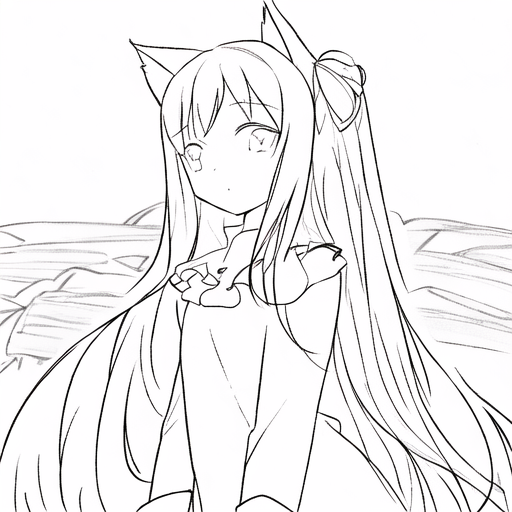

In [30]:
prompt = "best quality, masterpiece, 1girl, long hair, cat ears, standing"

image1 = pipeS(prompt, height=512, width=512,num_inference_steps=50, guidance_scale =6).images[0]  # OK
image1